In [20]:
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt

args = {"t": 10,
        "resolution": np.array([250, 250])}

In [21]:
# Remove tick marks
plt.rcParams["xtick.bottom"] = plt.rcParams["ytick.left"] = False
# Remove labels
plt.rcParams["xtick.labelbottom"] = plt.rcParams["ytick.labelleft"] = False
# Make figures bigger
plt.rcParams["figure.figsize"] = (8,8)
# Change the colour mapping
plt.rcParams['image.cmap'] = "inferno"

## Simulating Images
This part of the notebook is focused on generating images and properties of a CCD

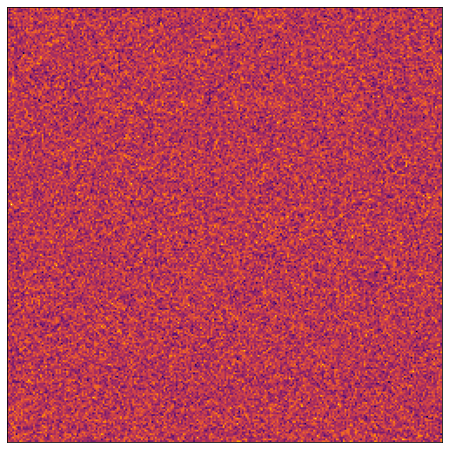

In [22]:
# Bias Frame
# Mean pixel value of 20 counts, std deviation 1. Means generating 1 billion pixel images, and still won't have a 0.
def generate_bias(**kwargs):
    return rng.normal(20, 1, kwargs['resolution']).astype(int)

plt.imshow(generate_bias(**args))
plt.show()

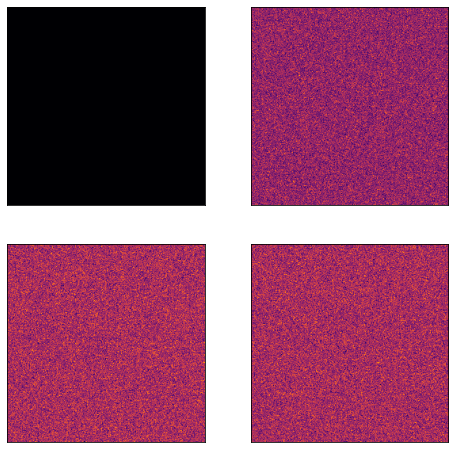

In [23]:
# Generate a dark current
# Uses a Poisson distribution of 5 electrons per pixel per second
def generate_dark_current(**kwargs):
    time = kwargs["t"]
    res = kwargs["resolution"]
    return rng.poisson(5*time, res).astype(int)


fig, axes = plt.subplots(nrows=2, ncols=2)

for i, ax in enumerate(axes.flatten()):
    ax.imshow(generate_dark_current(t=4*i,
                                    resolution=args["resolution"]))
plt.show()

In [24]:
# Sensitivity/vignetting of CCD
def generate_sensitivity(**kwargs):
    N = 500_000
    resolution = kwargs['resolution']
    # Randomly pick a point to act as the centre of vingetting
    centre = rng.multivariate_normal(resolution/2, [[10, 0], [0, 10]]).astype(int)
    
    # Randomly generate coordinates to sample, around the centre of vignetting
    # This seems like a good covariance matrix.
    covariance = 6 * np.array([[resolution[0], 0            ],
                                 [0            , resolution[1]]])
    coords = rng.multivariate_normal(centre, covariance, N).astype(int)
    # Make sure none of the values are below 0, or above the maximum value
    coords[coords < 0] = 0
    coords = np.mod(coords, resolution)
    # Convert to a form that can be used to index an 2D array
    i, j = coords.T
    
    # Change in sensitivity pixel-to-pixel is given by the fact we assign each pixel a sum of random numbers, then normalise the array (so max is 1).
    # Vignetting/radial sensitivity is given by the fact the coordinates we are indexing to assign random sensitivities to are based on a normal distribution.
    vals = np.ones(resolution)
    vals[i, j] += rng.random(N)
    sensitivity_mask = vals / np.max(vals)
    
    return sensitivity_mask

plt.imshow(generate_sensitivity(**args))
plt.show()

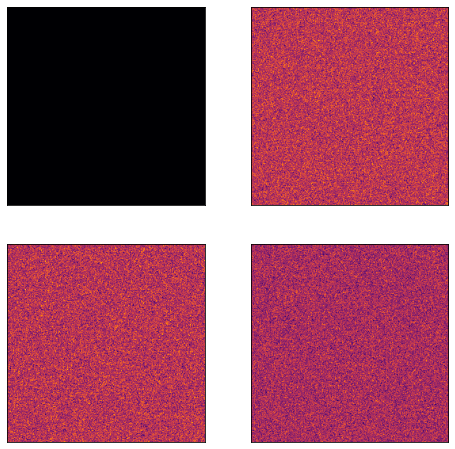

In [25]:
# Generate a uniform stream of photons
# Uses a Poisson distribution
def generate_uniform(**kwargs):
    time = kwargs['t']
    resolution = kwargs['resolution']
    return rng.poisson(100*time, resolution).astype(int)


fig, axes = plt.subplots(nrows=2, ncols=2)

for i, ax in enumerate(axes.flatten()):
    ax.imshow(generate_uniform(t=4*i,
                               resolution=args["resolution"]))
plt.show()

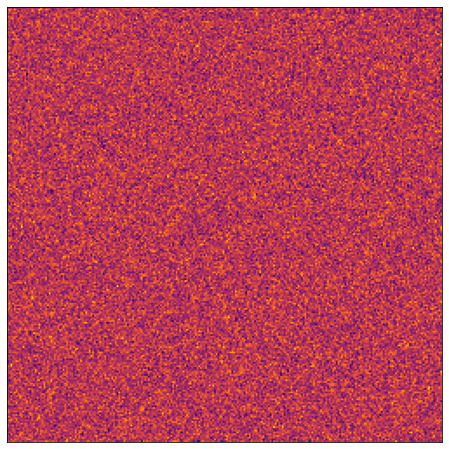

In [29]:
# Generate a uniform background of a mean intensity per second (ips) over an integration of time t.
# At this point you should've noticed the fact uniform, background, and dark current are modelled the same way.
def generate_background(ips, **kwargs):
    time = kwargs['t']
    resolution = kwargs['resolution']
    return rng.poisson(ips*time, resolution).astype(int)

# Simulate a star of a certain mean intensity per second (ips) and radius r, at a position pos, an integration time t, 
def generate_star(pos, r, ips, **kwargs):
    time = kwargs['t']
    resolution = kwargs['resolution']
    N = int(np.pi * r * r)  # no of pixels to sample
    # coords is to sample the space that will produce photons.
    # Towards the centre of the star is more likely to produce photons.
    # r = 3 sigma => sigma = r/3
    sigma = 0.3 * np.array([[r, 0],
                            [0, r]])
    covariance = sigma**2
    coords = rng.multivariate_normal(pos, covariance, N).astype(int)
    # Make sure none of the values are below 0, or above the maximum value
    coords[coords < 0] = 0
    coords = np.mod(coords, resolution)
    # Convert to a form that can be used to index an 2D array
    i, j = coords.T
    
    # Generate the blank image, and use the spatial sampling to then generate the number of photons each pixel region produces.
    image = np.zeros(resolution, dtype=int)
    # ips per pixel given by dividing ips by the area
    image[i, j] += rng.poisson(ips * time)
    return image


plt.imshow(generate_background(100, **args))
plt.show()

plt.imshow(generate_star([75, 75], 10, 300, **args))
plt.show()

plt.imshow(generate_background(100, **args) + generate_star([75, 75], 10, 100, **args))
plt.show()

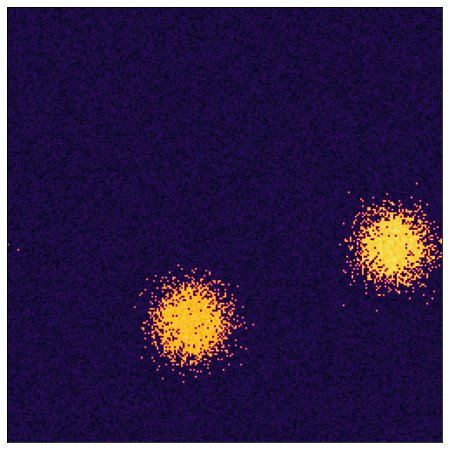

In [32]:
# Generate several stars and a background
def generate_star_map(intensity, **kwargs):
    resolution = kwargs["resolution"]
    star_no = rng.integers(1, 5)
    star_pos = (0.8 * rng.random((star_no, 2)) + 0.1) * resolution
    star_radius = (0.1*rng.random(star_no) + 0.1) * np.mean(resolution)
    star_intensity = intensity * (0.5 * rng.random() + 0.75)
    
    # Check none of them intersect
    # A quick way to get the norm of the distance vectors between each pair
    distances = np.linalg.norm(star_pos - star_pos[np.newaxis].transpose((1, 0, 2)),
                               axis=2)
    # Getting the sum of radii of each pair in a similar way (but fewer dimensions)
    radii_sum = star_radius + star_radius[np.newaxis].transpose()
    
    # Make it so the diagonal of distances is larger than radii, otherwise we count circles intersecting with themselves
    distances += 2**30 * np.eye(star_no)
    
    if (radii_sum <= distances).all():
        # Then no stars are intersecting and it's fine
        return {"N": star_no, "pos": star_pos, "r": star_radius, "ips": star_intensity}
    else:
        # Generate some new stars (not very efficient)
        return generate_star_map(intensity, **kwargs)
    

def generate_sky_photons(star_map, background_intensity, **kwargs):
    image = generate_background(background_intensity, **kwargs)
    for i in range(star_map["N"]):
        # Add stars to image
        image += generate_star(star_map["pos"][i], 
                               star_map["r"][i], 
                               star_map["ips"], 
                               **kwargs)
    return image.astype(int)

star_map = generate_star_map(100, **args)
sky = generate_sky_photons(star_map, 100, **args)

plt.imshow(sky)
plt.show()

## Reducing Images
This part of the notebook now focuses on creating an instance of a portion of sky to image with a CCD. No knowledge of the previous section is necessary.

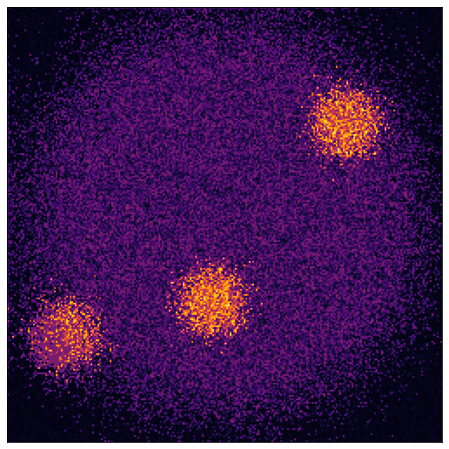

In [37]:
# Create an image on a CCD
I = 100  # Intensity
RES = np.array([250, 250])  # Resolution
ARGS = {"t": 10,
        "resolution": RES}

# These won't change between images
bias = generate_bias(**ARGS)
sensitivity = generate_sensitivity(**ARGS)
star_map = generate_star_map(I, **ARGS)

def generate_raw_image(bias, sensitvity, star_map, **ARGS):
    image = np.copy(bias)
    image += generate_dark_current(**ARGS)
    image += (sensitivity * generate_sky_photons(star_map, I, **ARGS)).astype(int)
    return image

raw = generate_raw_image(bias, sensitivity, star_map, **ARGS)
plt.imshow(raw)
plt.show()

In [38]:
# Image reduction techniques
def generate_scientific_image(raw, bias, dark, flat):
    return (raw - bias - dark) / flat

# These are the exposures we take to turn into dark frames and flat fields
def generate_dark_exposure(bias, **ARGS):
    return bias + generate_dark_current(**ARGS)

def generate_flat_exposure(bias, sensitivity, **ARGS):
    # Create a uniform exposure
    exposure = sensitivity * generate_uniform(**ARGS)
    return bias + generate_dark_current(**ARGS) + exposure

# These are how we produce dark frames etc.
def generate_dark_frame(bias, exposure):
    return exposure - bias

def generate_flat_field(bias, dark_frame, exposure):
    not_normalised = exposure - dark_frame - bias
    return not_normalised / np.mean(not_normalised)

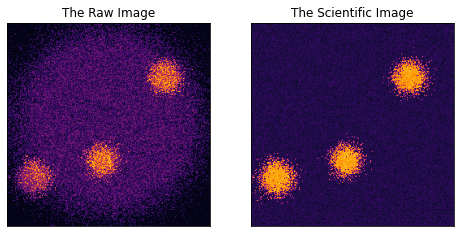

In [40]:
# Generate an image using the CCD above
raw = generate_raw_image(bias, sensitivity, star_map, **ARGS)
# Produce a dark frame by taking an exposure
dark_frame = generate_dark_frame(bias, generate_dark_exposure(bias, **ARGS))

# Produce a flat field using one exposure, and the dark_frame
flat_field = generate_flat_field(bias,
                                 dark_frame, 
                                 generate_flat_exposure(bias, sensitivity, **ARGS))

# Produce a scientific image, and compare it to the raw one
reduced = generate_scientific_image(raw, bias, dark_frame, flat_field)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.imshow(raw)
ax1.set_title("The Raw Image")

ax2.imshow(reduced)
ax2.set_title("The Scientific Image")

plt.show()

In [41]:
# Generate several raw images using the CCD above
raw_list = [generate_raw_image(bias, sensitivity, star_map, **ARGS) for _ in range(4)]
# Produce a master dark frame by taking several exposures and averaging
dark_frames = [generate_dark_frame(bias, generate_dark_exposure(bias, **ARGS)) for _ in range(5)]
master_dark = np.median(np.stack(dark_frames), axis=0)

# Produce a flat field using many exposures, and the master dark
exposures = [generate_flat_exposure(bias, sensitivity, **ARGS) for _ in range(5)]
median_exposure = np.median(np.stack(exposures), axis=0)

flat_field = generate_flat_field(bias,
                                 master_dark, 
                                 median_exposure)

# Produce a scientific image, and compare it to the raw one
reduced_list = [generate_scientific_image(raw, bias, master_dark, flat_field) for raw in raw_list]
reduced = np.median(np.stack(reduced_list), axis=0)